In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint

from scipy.optimize import curve_fit

import torchvision.transforms as transforms
from sklearn import preprocessing
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
import statsmodels.formula.api as smf
os.chdir("..")
os.getcwd()




import importlib.util

spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

### Purpose of this notebook: 

# PoC for a multidimensional modeling using logistic regression

# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#prep_data

data_dict = prep_data.prep_data_all_epochs(results_from_file, 
              results_val_from_file, 
              results_4500_from_file, 
              min_epoch = 20)

# the following unacks all dict items into a corresonding variable:
locals().update(data_dict)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  accs &  plane &   car &  bird &    cat &    deer &    dog &    frog &  horse &   ship &  truck &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.20 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              20 &              4999.00 \\
1 &  0.25 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              25 &              4999.00 \\
2 &  0.24 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              30 &              4999.00 \\
3 &  0.26 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              35 &              4999.00 \\
4 &  0.29 & 145.00 & 31.00 & 97.00 & 496.00 & 1096.00 & 307.00 & 2382.00 &   9.00 & 373.00 &  63.00 &              40 &              4999.00 \\
\

,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


(12, 10800)


,itterations,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size
0,0,0.7703,95.387190,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,20,45500.0
1,0,0.7833,95.093551,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,25,45500.0
2,0,0.7774,94.994801,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,30,45500.0
3,0,0.7967,94.904114,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,35,45500.0
4,0,0.8035,95.364757,5000.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,4500.0,40,45500.0


# logreg - full option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [3]:
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained"
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + np.power(epochs_trained, 2)"
formula = "accs ~ plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained + np.power(epochs_trained, 2) + I(plane + car + bird + cat + deer + dog + frog + horse + ship + truck) : epochs_trained"
formula = "accs ~ (plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained) ** 2"
formula


'accs ~ (plane + car + bird + cat + deer + dog + frog + horse + ship + truck + epochs_trained) ** 2'

In [4]:
tmp = smf.glm(formula=formula, data=results, family=sm.families.Binomial()).fit()
print(tmp.summary())
tmp.fittedvalues

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   accs   No. Observations:                 9720
Model:                            GLM   Df Residuals:                     9653
Model Family:                Binomial   Df Model:                           66
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4035.8
Date:                Mon, 21 Aug 2023   Deviance:                       73.639
Time:                        10:35:20   Pearson chi2:                     73.5
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07265
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.8921 

0       0.344121
1       0.346521
2       0.348930
3       0.351346
4       0.353770
          ...   
9715    0.808552
9716    0.809805
9717    0.811051
9718    0.812291
9719    0.813525
Length: 9720, dtype: float64

In [5]:
#results = pd.concat([pd.DataFrame({"accs_hat_glm_form": tmp.fittedvalues}), results], axis=1)
results["accs_hat_glm_form"] = tmp.fittedvalues
results.head(2)

,accs,training_times,plane,car,bird,cat,deer,dog,frog,horse,ship,truck,epochs_trained,total_training_size,accs_hat_glm_form
0,0.2030,0.004924,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.000000,0.000025,0.344121
1,0.2506,0.001595,0.026474,0.005604,0.017044,0.098679,0.217723,0.060096,0.474814,0.001601,0.074059,0.012402,0.028571,0.000025,0.346521


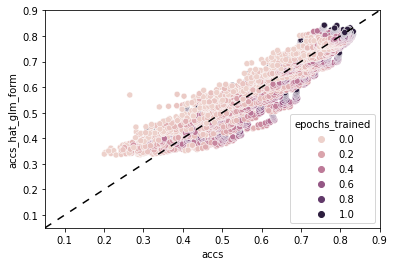

0.9108822444931832

In [6]:
sns.scatterplot(data = results, x="accs", y = "accs_hat_glm_form", hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.show()

metrics.r2_score(results.accs, results.accs_hat_glm_form)